#Part 1: Importing Required Libraries

In [ ]:
# for numerical operations
import numpy as np
# to store and analysis data in dataframes
import pandas as pd
#for graphs
import matplotlib.pyplot as plt
#for advanced visualisations
import plotly.express as px

#for future prediction
from fbprophet import Prophet
#for model accuracy
from fbprophet.diagnostics import performance_metrics,cross_validation

#Part 2: Pre-processing data

In [ ]:
#importing data
confirmed_global_url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
death_global_url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
recovered_global_url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'
population_density_url = 'https://raw.githubusercontent.com/SriKaavya/AlgorithmsProject/master/data%20(1).csv'
global test,y_values,yhat_values


In [ ]:
# creating class
def cases_by_date(df, case_type):
    cases_by_date = pd.melt(df, id_vars=['Province/State','Country/Region','Lat','Long'], var_name='Date', value_name=case_type)
    return cases_by_date

In [ ]:
#converting data into dataframe using pandas
confirmed_df = pd.read_csv(confirmed_global_url)
death_df = pd.read_csv(death_global_url)
recovered_df = pd.read_csv(recovered_global_url)
density_df = pd.read_csv(population_density_url, usecols = ["Country/Region","density"])

In [ ]:
# using created class to sort by date
confirmed_cases_df = cases_by_date(confirmed_df,'Confirmed')
death_cases_df = cases_by_date(death_df,'Death')
recovered_cases_df = cases_by_date(recovered_df,'Recovered')
confirmed_cases_df.head()

,Province/State,Country/Region,Lat,Long,Date,Confirmed
0,NaN,Afghanistan,33.93911,67.709953,1/22/20,0
1,NaN,Albania,41.15330,20.168300,1/22/20,0
2,NaN,Algeria,28.03390,1.659600,1/22/20,0
3,NaN,Andorra,42.50630,1.521800,1/22/20,0
4,NaN,Angola,-11.20270,17.873900,1/22/20,0


In [ ]:
#combining data
combined_df = confirmed_cases_df.join(death_cases_df['Death']).join(recovered_cases_df['Recovered'])
cases_per_day = combined_df.groupby(['Date','Country/Region'],as_index=False)[['Confirmed','Death', 'Recovered']].sum()
#checking for null values
combined_df.isnull().sum()

Province/State    51336
Country/Region        0
Lat                   0
Long                  0
Date                  0
Confirmed             0
Death                 0
Recovered          3588
dtype: int64

In [ ]:
cases_per_day = combined_df.groupby(['Date','Country/Region'],as_index=False)[['Confirmed','Death', 'Recovered']].sum()
cases_reg=pd.merge(cases_per_day, density_df, on='Country/Region')

In [ ]:
max_density = cases_reg['density'].max()
min_density = cases_reg['density'].min()
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73692 entries, 0 to 73691
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Province/State  22356 non-null  object 
 1   Country/Region  73692 non-null  object 
 2   Lat             73692 non-null  float64
 3   Long            73692 non-null  float64
 4   Date            73692 non-null  object 
 5   Confirmed       73692 non-null  int64  
 6   Death           73692 non-null  int64  
 7   Recovered       70104 non-null  float64
dtypes: float64(3), int64(2), object(3)
memory usage: 4.5+ MB


In [ ]:
#converting combined data into csv file
combined_df.to_csv('combined_data.csv',index=False)
cases_per_day.to_csv('cases_per_day.csv')

#Part3: Data Analysis

In [ ]:
df = combined_df.copy()

In [ ]:
df.drop(columns=['Province/State','Lat','Long'],inplace=True)
df.columns = ['country','date','confirmed','deaths','recovered']

Part3.1: Active cases

In [ ]:
confirmed = df["confirmed"]
recovered = df["recovered"]
deaths = df["deaths"]
active_case=[]
for x in range(len(confirmed)): 
    active_case.append(confirmed[x]-recovered[x]-deaths[x])
#df.tail(1)
active_case = pd.Series(active_case)
print(active_case)


0            0.0
1            0.0
2            0.0
3            0.0
4            0.0
          ...   
73420    48699.0
73421        9.0
73422     1460.0
73423    15689.0
73424     8006.0
Length: 73425, dtype: float64


In [ ]:
df["active_case"] = active_case
#create copy of data base for future prediction
corona_df=df[["date","active_case"]]

#max total active case
df[["date",'country',"active_case"]].max()

date           2020-10-22 00:00:00
country                   Zimbabwe
active_case            8.18467e+06
dtype: object

Part3.2: Top 10 countries with max confirmed cases

In [ ]:
countries = df['country'].values

In [ ]:
country_wise_total_confirmed = {}
for country in countries:
    data_temp = df[df['country'] == country]
    country_wise_total_confirmed[country] = data_temp['confirmed'].max()

In [ ]:
#top 10 countries on worst codition
from collections import Counter
k1 = Counter(country_wise_total_confirmed)
cw_confirmed = k1.most_common(10)

In [ ]:
cw_confirmed

[('US', 8407702),
 ('India', 7761312),
 ('Brazil', 5323630),
 ('Russia', 1453923),
 ('Argentina', 1053650),
 ('Spain', 1026281),
 ('France', 1007026),
 ('Colombia', 990373),
 ('Peru', 879876),
 ('Mexico', 874171)]

Part 3.3: top 10 country with highest deaths

In [ ]:
country_wise_total_deaths = {}
for country in countries:
    data_temp = df[df['country'] == country]
    country_wise_total_deaths[country] = data_temp['deaths'].max()

In [ ]:
#top 10 countries on worst codition
from collections import Counter
k2 = Counter(country_wise_total_deaths)
cw_death = k2.most_common(10)

In [ ]:
cw_death

[('US', 223032),
 ('Brazil', 155900),
 ('India', 117306),
 ('Mexico', 87415),
 ('United Kingdom', 44347),
 ('Italy', 36968),
 ('Spain', 34521),
 ('Peru', 33984),
 ('France', 33939),
 ('Iran', 31650)]

Part 3.4: Death rate

In [ ]:
df1 = df['deaths'] / df['confirmed'] 
df['death_rate'] = df1

In [ ]:
df.tail()

,country,date,confirmed,deaths,recovered,active_case,death_rate
73420,West Bank and Gaza,2020-10-22,49134,435,0.0,48699.0,0.008853
73421,Western Sahara,2020-10-22,10,1,0.0,9.0,0.100000
73422,Yemen,2020-10-22,2057,597,0.0,1460.0,0.290228
73423,Zambia,2020-10-22,16035,346,0.0,15689.0,0.021578
73424,Zimbabwe,2020-10-22,8242,236,0.0,8006.0,0.028634


Part 3.5: Recovery rate

In [ ]:
recovery =round(recovered/confirmed*100, 2)
recovery_rate= list(map("{}%".format, recovery))

df['recovery_rate']=recovery_rate
df.tail()

,country,date,confirmed,deaths,recovered,active_case,death_rate,recovery_rate
73420,West Bank and Gaza,2020-10-22,49134,435,0.0,48699.0,0.008853,0.0%
73421,Western Sahara,2020-10-22,10,1,0.0,9.0,0.100000,0.0%
73422,Yemen,2020-10-22,2057,597,0.0,1460.0,0.290228,0.0%
73423,Zambia,2020-10-22,16035,346,0.0,15689.0,0.021578,0.0%
73424,Zimbabwe,2020-10-22,8242,236,0.0,8006.0,0.028634,0.0%


Part 3.6: Active rate

In [ ]:
df3 = df['active_case'] / df['confirmed'] 
df['active_rate'] = df3

In [ ]:
df.tail()

,country,date,confirmed,deaths,recovered,active_case,death_rate,recovery_rate,active_rate
73420,West Bank and Gaza,2020-10-22,49134,435,0.0,48699.0,0.008853,0.0%,0.991147
73421,Western Sahara,2020-10-22,10,1,0.0,9.0,0.100000,0.0%,0.900000
73422,Yemen,2020-10-22,2057,597,0.0,1460.0,0.290228,0.0%,0.709772
73423,Zambia,2020-10-22,16035,346,0.0,15689.0,0.021578,0.0%,0.978422
73424,Zimbabwe,2020-10-22,8242,236,0.0,8006.0,0.028634,0.0%,0.971366


Part 3.7: Highest active cases

In [ ]:
df = df.sort_values(['active_case'],ascending=False) 
df[['country','active_case']].iloc[1]


country                 US
active_case    8.11386e+06
Name: 73134, dtype: object

 Part 3.8: Tests per confirmed cases

In [ ]:
df0 = pd.read_csv('/content/drive/My Drive/Major Project/tests-per-confirmed-case-daily.csv')

In [ ]:
df0.drop(columns=['Code'],inplace=True)
df0.columns=['country','date','tests per confirmed']

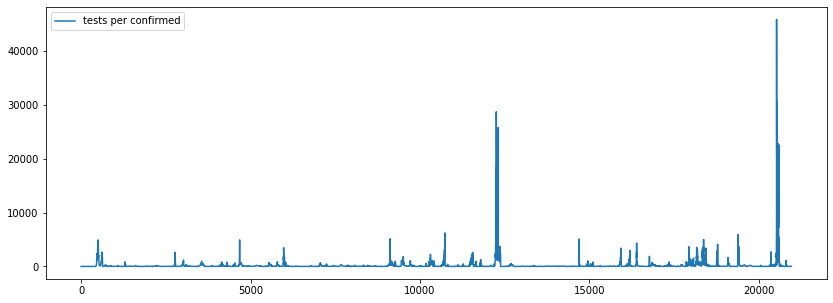

In [ ]:
df0.plot(kind='line',figsize=(14,5))

Part 3.9: positivity rate

In [ ]:
posititvity_rate = pd.read_csv('/content/drive/My Drive/Major Project/positive-rate-daily.csv')

In [ ]:
posititvity_rate.drop(columns=['Code'],inplace=True)
posititvity_rate.columns=['country','date','workplace']
posititvity_rate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21273 entries, 0 to 21272
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   country    21273 non-null  object 
 1   date       21273 non-null  object 
 2   workplace  21273 non-null  float64
dtypes: float64(1), object(2)
memory usage: 498.7+ KB


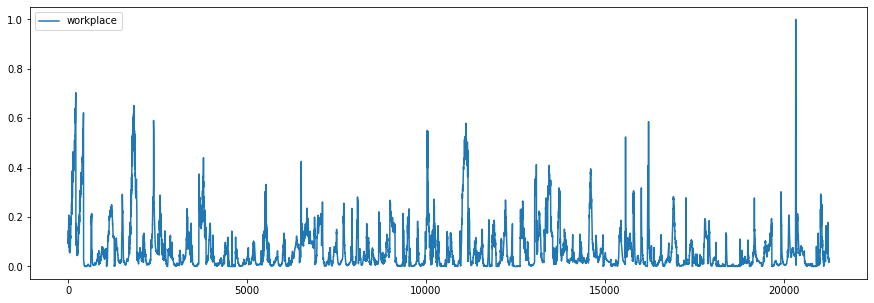

In [ ]:
posititvity_rate.plot(kind='line',figsize=(15,5))

Part 3.10) cumulative confirmed cases

In [ ]:
df1 = pd.read_csv('/content/WHO-COVID-19-global-data (1).csv')
df1.drop(columns=[' Country_code',' WHO_region'],inplace=True)
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69325 entries, 0 to 69324
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Date_reported       69325 non-null  object
 1    Country            69325 non-null  object
 2    New_cases          69325 non-null  int64 
 3    Cumulative_cases   69325 non-null  int64 
 4    New_deaths         69325 non-null  int64 
 5    Cumulative_deaths  69325 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 3.2+ MB


In [ ]:
df1.columns = ['date','country','new_cases','cumulative_case','new_deaths','cumulative_deaths']
df1.head()


,date,country,new_cases,cumulative_case,new_deaths,cumulative_deaths
0,2020-01-03,Afghanistan,0,0,0,0
1,2020-01-04,Afghanistan,0,0,0,0
2,2020-01-05,Afghanistan,0,0,0,0
3,2020-01-06,Afghanistan,0,0,0,0
4,2020-01-07,Afghanistan,0,0,0,0


#Part4: Data Visualisation

Comparison between countries : USA, Italy, India, France, China, Canada, Russia, Germany


In [ ]:
#US data
confirmed_cases_us = df1[df1["country"] == "United States of America"].groupby(["date"]).cumulative_case.sum()
fatal_cases_us = df1[df1["country"] == "United States of America"].groupby(["date"]).cumulative_deaths.sum()

#Italy data
confirmed_cases_italy = df1[df1["country"] == "Italy"].groupby(["date"]).cumulative_case.sum()
fatal_cases_italy = df1[df1["country"] == "Italy"].groupby(["date"]).cumulative_deaths.sum()

#India data
confirmed_cases_india = df1[df1["country"] == "India"].groupby(["date"]).cumulative_case.sum()
fatal_cases_india = df1[df1["country"] == "India"].groupby(["date"]).cumulative_deaths.sum()

#France data
confirmed_cases_france = df1[df1["country"] == "France"].groupby(["date"]).cumulative_case.sum()
fatal_cases_france = df1[df1["country"] == "France"].groupby(["date"]).cumulative_deaths.sum()

#China data
confirmed_cases_china = df1[df1["country"] == "China"].groupby(["date"]).cumulative_case.sum()
fatal_cases_china = df1[df1["country"] == "China"].groupby(["date"]).cumulative_deaths.sum()

#Canada data
confirmed_cases_canada = df1[df1["country"] == "Canada"].groupby(["date"]).cumulative_case.sum()
fatal_cases_canada = df1[df1["country"] == "Canada"].groupby(["date"]).cumulative_deaths.sum()

#Germany data
confirmed_cases_germany = df1[df1["country"] == "Germany"].groupby(["date"]).cumulative_case.sum()
fatal_cases_germany = df1[df1["country"] == "Germany"].groupby(["date"]).cumulative_deaths.sum()

date = df1["date"].unique()


[]

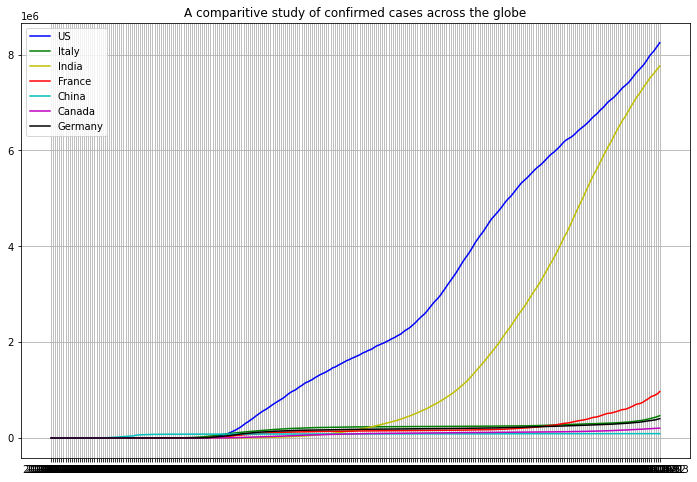

In [ ]:
plt.figure(figsize = (12,8))
plt.plot(date, confirmed_cases_us, color = "b", label = "US")
plt.plot(date, confirmed_cases_italy, color = "g", label = "Italy")
plt.plot(date, confirmed_cases_india, color = "y", label = "India")
plt.plot(date, confirmed_cases_france, color = "r", label = "France")
plt.plot(date, confirmed_cases_china, color = "c", label = "China")
plt.plot(date, confirmed_cases_canada, color = "m", label = "Canada")
plt.plot(date, confirmed_cases_germany , color = "k", label = "Germany")
plt.grid("both")
plt.title("A comparitive study of confirmed cases across the globe")
plt.legend()

plt.plot()

[]

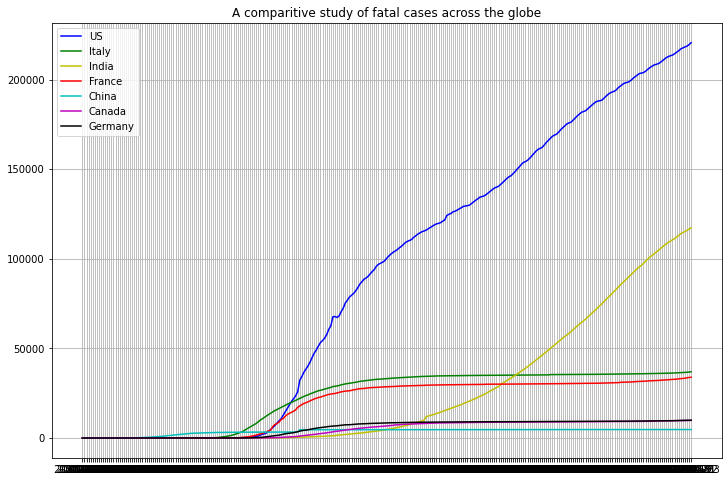

In [ ]:
plt.figure(figsize = (12, 8))
plt.plot(date, fatal_cases_us, color = "b", label = "US")
plt.plot(date, fatal_cases_italy, color = "g", label = "Italy")
plt.plot(date, fatal_cases_india, color = "y", label = "India")
plt.plot(date, fatal_cases_france, color = "r", label = "France")
plt.plot(date, fatal_cases_china, color = "c", label = "China")
plt.plot(date, fatal_cases_canada, color = "m", label = "Canada")
plt.plot(date, fatal_cases_germany , color = "k", label = "Germany")
plt.grid("both")
plt.title("A comparitive study of fatal cases across the globe")
plt.legend()

plt.plot()

Global Visualisation using Chloropeth Maps

In [ ]:
choro_map = px.choropleth(df1, locations = "country", locationmode = "country names", color = "cumulative_case",
                                        hover_name = 'country', animation_frame = "date")
choro_map.update_layout(title_text = "Global Confirmed Deaths", title_x = 0.5, 
                         geo = dict(showframe = False, showcoastlines = True))
choro_map.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
choro_map2 = px.choropleth(df1, locations = "country", locationmode = "country names", color = "cumulative_deaths",
                                        hover_name = 'country', animation_frame = "date")
choro_map2.update_layout(title_text = "Global Confirmed Deaths", title_x = 0.5, 
                         geo = dict(showframe = False, showcoastlines = True))
choro_map2.show()

Output hidden; open in https://colab.research.google.com to view.

#Part5: Forecasting

In [ ]:
combined_df = pd.read_csv('/content/drive/My Drive/Major Project/combined_data.csv')

In [ ]:
def shutdown(ds):
    date = pd.to_datetime(ds)
    if date.month > 3:
        return 0
    else:
        return 1

def density(density):
    if density > (max_density - min_density)/2:
        return 1
    else:
        return 0


def per_country(combined_df):
    cases_per_day = combined_df.groupby(['Date','Country/Region'],as_index=False)[['Confirmed','Death', 'Recovered']].sum()
    cases_by_country=pd.merge(cases_by_country, density_df, on='Country/Region')
    max_density = cases_reg['density'].max()
    min_density = cases_reg['density'].min()
    cases_by_country.tail()
    return cases_by_country

In [ ]:
#Global case prediction
def global_cases_prediction(cases_reg,type_input):
    confirmed_df = cases_reg[['Date',type_input,'density']]
    confirmed_df.columns = ['ds','y','density']
    train=confirmed_df.sample(frac=0.8,random_state=200) #random state is a seed value
    test=confirmed_df.drop(train.index)
    p = Prophet()
    p.add_regressor('shutdown')
    p.add_regressor('density')
    p.add_seasonality(name = "daily", period = 30.5, fourier_order = 5)
    train.loc[:,'shutdown'] = train.loc[:,'ds'].apply(shutdown)
    train.loc[:,'density'] = train.loc[:,'density'].apply(density)
    confirmed_df.head()
    p.fit(train)
    test.loc[:,'shutdown'] = test.loc[:,'ds'].apply(shutdown)
    test.loc[:,'density'] = test.loc[:,'density'].apply(density)
    forecast = p.predict(test)
    p.plot_components(forecast)
    forecast_df = forecast.groupby('ds')['yhat'].sum()
    print(forecast.groupby('ds')['yhat'].sum())
    test.loc[:,'ds'] = test.loc[:,'ds'].apply(lambda x: pd.to_datetime(x))
    p.plot_components(forecast)
    return forecast_df

In [ ]:
#Per country
def confirmed_case_prediction_per_country(cases_by_country,country,type_input):
        y_values = []
        yhat_values = []
        country_confirmed_df = cases_by_country[(cases_by_country['Country/Region'] == country)]
        print(country_confirmed_df.info())
        confirmed_df = country_confirmed_df[['Date',type_input ,'density']]
        print(confirmed_df.info())
        confirmed_df.columns = ['ds','y','temp','density']

        train = confirmed_df[:88]
        test = confirmed_df[88:]

        p = Prophet()
        p.add_regressor('shutdown')
        p.add_regressor('density')
        p.add_seasonality(name = "daily", period = 30.5, fourier_order = 5)
        train.loc[:,'shutdown'] = train.loc[:,'ds'].apply(shutdown)
        train.loc[:,'density'] = train.loc[:,'density'].apply(density)
        p.fit(train)
        test.loc[:,'shutdown'] = test.loc[:,'ds'].apply(shutdown)
        test.loc[:,'density'] = test.loc[:,'density'].apply(density)
        forecast = p.predict(test)
        p.plot(forecast)
        forecast_df = forecast.groupby('ds')['yhat'].sum()
        test.loc[:,'ds'] = test.loc[:,'ds'].apply(lambda x: pd.to_datetime(x))
        #result_val_df = forecast_df.merge(test, on=['ds'])
        #y_values += list(result_val_df['y'].values)
        #yhat_values += list(forecast_df['yhat'].values)
        p.plot_components(forecast)
        return forecast_df

Choose global or country for prediction:global
Choose between Recovered, Deaths and Confirmed for prediction:Recovered


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Found custom seasonality named 'daily', disabling built-in 'daily' seasonality.


ds
2020-01-22   -2.571525e+05
2020-01-23   -2.422773e+05
2020-01-24   -3.102521e+04
2020-01-25    6.558840e+04
2020-01-26   -5.406448e+04
                  ...     
2020-10-19    1.863646e+06
2020-10-20    2.905464e+06
2020-10-21    2.488033e+06
2020-10-22    2.453466e+06
2020-10-23    2.113500e+06
Name: yhat, Length: 276, dtype: float64


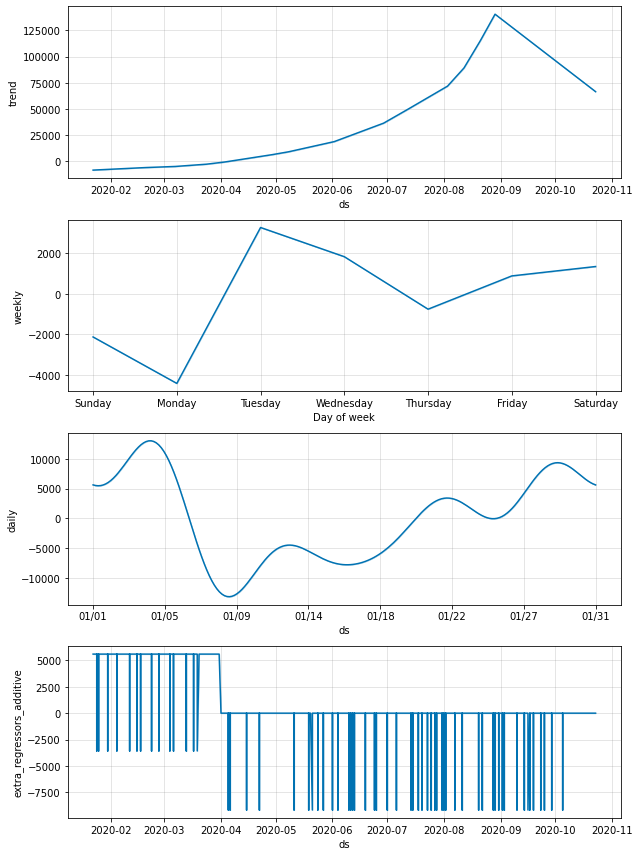

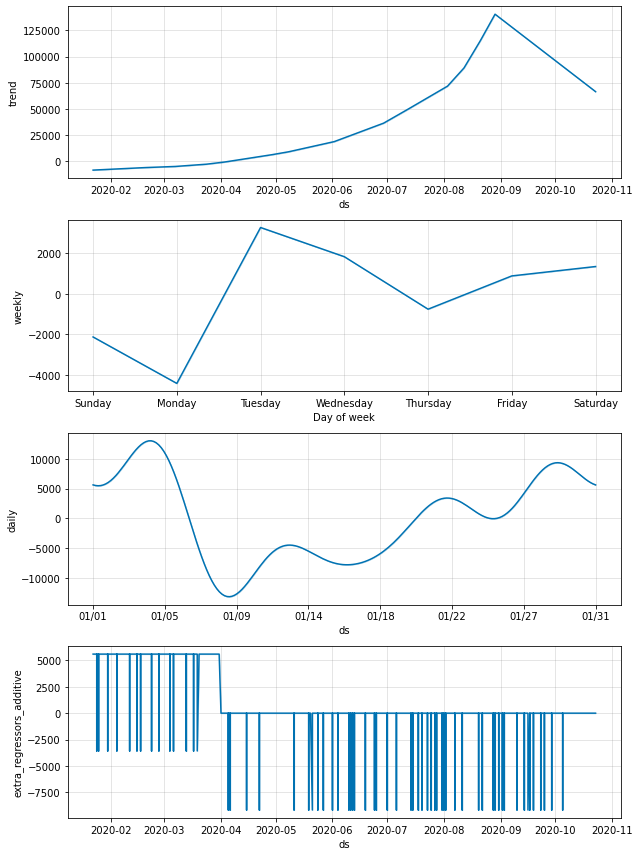

In [ ]:
exit = 0
while (exit == 0):
    user_input = input('Choose global or country for prediction:')
    type_input = input('Choose between Recovered, Deaths and Confirmed for prediction:')
    if user_input == 'global':
        pred = global_cases_prediction(cases_reg,type_input)
        exit = 1
    elif (user_input in combined_df['country'].unique()):
        per_country_cases = per_country(cases_reg)
        pred = confirmed_case_prediction_per_country(per_country_cases,user_input,type_input)
        exit = 1
    else:
        print('Choosen country please select from below:')
        print(combined_df['country'].unique())
        